# Asteroid Light Curve Examples - Part 1

This notebook contains examples deep learning techniques applied to the asteroid light curve data from http://alcdef.org.


# Objectives
- Understand when a convolutional neural network (CNN) might be applicable.
- See how to apply a 1D-CNN to time-series data.
- See how to build a more complex model that takes both time-series and categorical inputs. 

# Imports

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from glob import glob
from scipy.signal import resample
from collections import Counter

import random

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, MaxPooling1D, Flatten

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import pandas as pd
import seaborn as sns

# Load Dataset

Load data from Astroid Lightcurve Photometry Database (http://alcdef.org/)

In [2]:
def resample_light_curve(timestamps, intensities, nb_samples=100):
    '''Resample light curve to a given number of samples.'''
    r_intensities, r_timestamps = resample(intensities, num=nb_samples, t=timestamps)
    return r_timestamps, r_intensities

def to_float(v):
    try:
        return float(v)
    except:
        return None

def get_data_from_files(fns):
    all_objects = []
    item = None
    for fn in fns:
        with open(fn, 'r') as fh:
            item = {}
            for line in fh.readlines():
                line = line.strip()
                if line == 'ENDDATA':
                    item['DATA'] = np.array(item['DATA'])
                    yield item
                elif line == 'STARTMETADATA':
                    item = {}
                elif line == 'ENDMETADATA':
                    item['DATA'] = []
                elif line.startswith('DATA='):
                    values = line.strip().split('=')[1].split('|')
                    values = list(map(to_float, values))
                    item['DATA'].append(values)
                else:
                    try:
                        split_ndx = line.index('=')
                        k = line[:split_ndx]
                        v = line[split_ndx+1:]
                    except:
                        print(line)
                        raise
                    item[k] = v

In [3]:
fns = glob('data/ALCDEF_ALL/*.txt')
gen = get_data_from_files(fns)

min_samples = 100

# Gather all observations with at least 100 samples
data = []
for item in gen:
    if len(item['DATA']) < min_samples:
        continue
        
    # Resample item before moving on
    intensities = item['DATA'][:,1]
    timestamps = item['DATA'][:,0]
    r_timestamps, r_intensities = resample_light_curve(timestamps, intensities, nb_samples=min_samples)
    item['DATA_RESAMPLED'] = np.array([r_timestamps, r_intensities]).T
    data.append(item)
    

# Reduce Dataset to the Most Common Objects

In [4]:
# Select the most common nb_classes objects
nb_classes = 30

c = Counter([item['OBJECTNAME'] for item in data])
names = [ name for name, cnt in c.most_common(nb_classes) ]

print('Restricting dataset to the following objects:')
for name, cnt in c.most_common(nb_classes):
    print('  {:15} {}'.format(name, cnt))

sub_data = [ item for item in data if item['OBJECTNAME'] in names ]

Restricting dataset to the following objects:
  Ganymed         84
  Parthenope      77
  Zelinda         46
  Ate             45
  Leukothea       42
  Eudora          39
  Melanie         37
  Cupido          36
  Scania          33
  Eukrate         32
  Polyhymnia      32
  Philia          31
  Norma           31
  Lachesis        30
  Euterpe         30
  Aurelia         30
  Aline           29
  Pales           29
  Ounas           28
  Thora           28
  Jaroslawa       27
  1999 FH         26
  Siwa            25
  Elsa            25
  Petrina         25
  Virginia        25
  Kalypso         25
  Shapleya        24
  Laura           24
  Adeona          23


# Visualize Examples

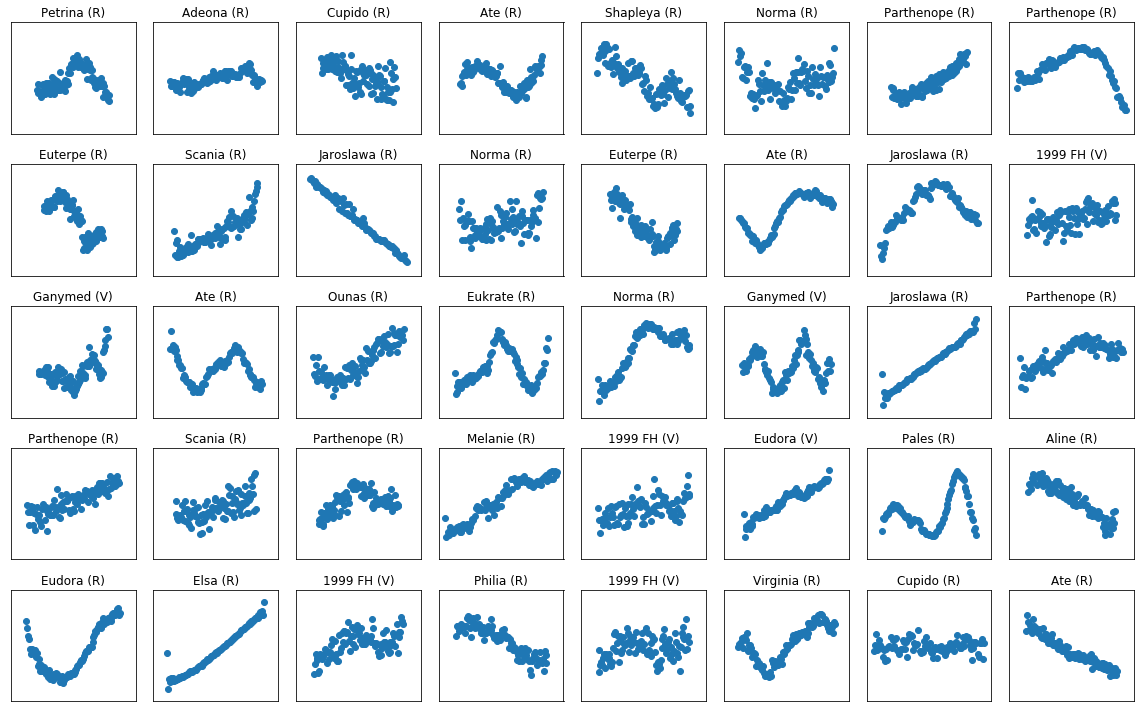

In [5]:
nrows=5
ncols=8
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols,2*nrows))
items = np.random.choice(sub_data, size=nrows*ncols, replace=False)
for ndx, item in enumerate(items):
    r = ndx//8
    c = ndx%8
    ax = axes[r,c]
    x = item['DATA_RESAMPLED'][:,0]
    y = item['DATA_RESAMPLED'][:,1]
    ax.scatter(x=x,y=y)
    ax.set_title('{} ({})'.format(item['OBJECTNAME'], item['MAGBAND']))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    #ax.axis('off')
plt.tight_layout()    

# Generate Train and Test Data Sets

In [8]:
X = np.array([ item['DATA_RESAMPLED'][:,1] for item in sub_data ])
y = np.array([ names.index(item['OBJECTNAME']) for item in sub_data ])

# Reserve 20% of the data for testing
# Startify the data split so that the train and test sets have the same class distribution

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

print('Generated train and test sets with the following sizes.')
print('Train X (features) {}, y (targets) {}'.format(X_train.shape, y_train.shape))
print('Test  X (features) {}, y (targets) {}'.format(X_test.shape, y_test.shape))

Generated train and test sets with the following sizes.
Train X (features) (814, 100), y (targets) (814,)
Test  X (features) (204, 100), y (targets) (204,)


# Try an MLP (multi-layer perceptron) similiar to the TLE Example

In [40]:
metric='acc'

nb_classes = len(names)

model = Sequential()
model.add(Dense(units=100,activation='relu', input_shape=(100,)))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=nb_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=[metric]
)

# keras is complaining that I need to evaluate the model before printing a summary
# model.predict(np.zeros((16,9)))

model.summary()

repeats = 500
# The repeats value here is used to artifically increase the size of our training set.
# This forces keras to treat <repeats> passes through the training set as a single epoch and we
# get to avoid a huge number of progress bars and short-term variance in metrics.

def normalize(X):
    return (X - np.mean(X, keepdims=True)) / np.std(X, keepdims=True)

model.fit(
    normalize(X_train.repeat(repeats, axis=0)),
    to_categorical(y_train.repeat(repeats, axis=0)),
    validation_data=(normalize(X_test), to_categorical(y_test)),
    epochs=1000,
    batch_size=16,
    callbacks=[EarlyStopping(patience=3, monitor='val_loss')],
    verbose=1
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_35 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_36 (Dense)             (None, 30)                3030      
Total params: 23,230
Trainable params: 23,230
Non-trainable params: 0
_________________________________________________________________
Train on 407000 samples, validate on 204 samples
Epoch 1/1000
407000/407000 [==============================] - 33s 80us/step - loss: 2.6541 - acc: 0.1658 - val_loss: 2.5475 - val_acc: 0.1618
Epoch 2/1000
407000/407000 [==============================] - 33s 82us/step - loss: 2.3827 - acc: 0.2343 - val_loss: 2.6531 - val_acc: 0.1716
Epoch 3/1000
407000/407000 [==============================] - 29s 72u

In [57]:
def plot_confusion_matrix(X,y,title):
    yhat = model.predict(normalize(X))
    cm = confusion_matrix(y, np.argmax(yhat, axis=1))
    a = pd.DataFrame(cm)
    a.columns = names
    a.index = names
    sns.heatmap(a, cmap=None, annot=True, linewidths=.1).set_title(title)

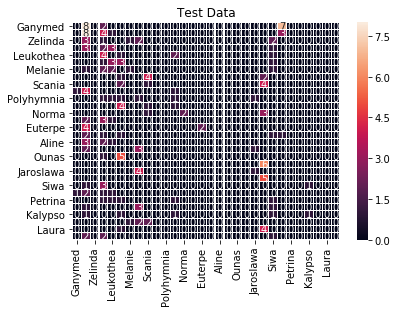

In [58]:
plot_confusion_matrix(X_test, y_test, 'Test Data')

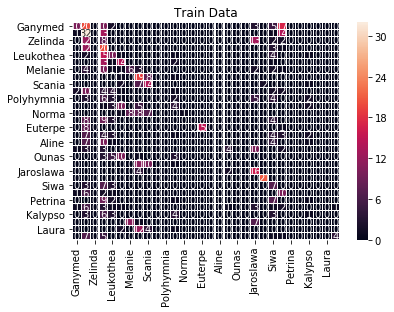

In [59]:
plot_confusion_matrix(X_train, y_train, 'Train Data')

# CNN Model

In [36]:
metric='acc'

nb_classes = len(names)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters=16, kernel_size=5, activation='relu'))
model.add(MaxPooling1D())

model.add(Flatten())
model.add(Dense(units=10,activation='relu'))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=nb_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[metric]
)

# keras is complaining that I need to evaluate the model before printing a summary
model.predict(np.zeros((16,100,1)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 96, 64)            384       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 48, 64)            0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 44, 32)            10272     
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 22, 32)            0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 18, 16)            2576      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 9, 16)             0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 144)               0         
__________

In [ ]:
repeats = 500
# The repeats value here is used to artifically increase the size of our training set.
# This forces keras to treat <repeats> passes through the training set as a single epoch and we
# get to avoid a huge number of progress bars and short-term variance in metrics.

def normalize(X):
    return (X - np.mean(X, keepdims=True)) / np.std(X, keepdims=True)

model.fit(
    np.expand_dims(normalize(X_train.repeat(repeats, axis=0)), axis=-1),
    to_categorical(y_train.repeat(repeats, axis=0)),
    validation_data=(np.expand_dims(normalize(X_test), axis=-1), to_categorical(y_test)),
    epochs=1000,
    batch_size=16,
    callbacks=[EarlyStopping(patience=3, monitor='val_loss')],
    verbose=1
)

# Light Curve Embedding Based on Extracted Features

__TODO__ : Add a visualization of the intermediate features learned by both the CNN and MLP above.